---

<h3 style="text-align: center;"><b> Градиентный спуск. Линейные модели.</b></h3>

В этом ноутбуке мы попробуем реализовать свой градиентный спуск на основе модели линейной регрессии.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
import scipy.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

### Построение модели

Модель нашей линейной регрессии:

In [2]:
# в этих переменных будут лежать веса, которые мы оценим
# W - веса модели, на которые умножаются признаки
W = None
# b - bias, который добавляется к итоговому результату
b = None

def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку между preds и y.
    """
    return ((preds - y)**2).mean()

def solve_weights(X, y):
    """
    Находит параметры W,b по методу наименьших квадратов для X и y.
    Решает систему линейных уравнений, к которым приводит метод наименьших 
    квадратов, для признаков X и значений y.
    """
    # ключевое слово global позволяет нам использовать глобальные переменные,
    # определенные в начале ячейки
    global W, b
    
    
    N = X.shape[0]
    # добавляем к признакам фиктивную размерность, чтобы было удобнее находить bias
    bias = np.ones((N, 1))
    X_b = np.append(bias, X, axis=1)
    
    # используем формулу из метода наименьших квадратов
    # W_full сожержит коэффициенты W и b, так как мы добавили фиктивную размерность к признакам
    W_full = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    
    # мы разделяем bias, который лежал в начале вектора W_full, и веса модели W
    W = W_full[1:]
    b = np.array([W_full[0]])
    # нам не нужно возвращать W и b, так как они уже лежат в глобальных переменных
    
def grad_descent(X, y, lr, num_iter=100):
    """
    Находит приближенные значения параметров модели, используя градиентный спуск.
    Функции потерь (ошибки) для данной реализации спуска - сумма квадратов ошибки.
    Возвращаемое значение - список значений ффункции потерь на каждом шаге.
    """
    # ключевое слово global позволяет нам использовать глобальные переменные,
    # определенные в начале ячейки
    global W, b
    W = np.random.rand(X.shape[1])
    b = np.array(np.random.rand(1))
    
    losses = []
    
    N = X.shape[0]
    for iter_num in range(num_iter):
        preds = predict(X)
        losses.append(mse(preds, y))
        
        w_grad = np.zeros_like(W)
        b_grad = 0
        for sample, prediction, label in zip(X, preds, y):
            w_grad += 2 * (prediction - label) * sample
            b_grad += 2 * (prediction - label)
            
        W -= lr * w_grad
        b -= lr * b_grad
    return losses

def predict(X):
    """
    Предсказывает значения y, используя текущие параметры модели W и b
    """
    global W, b
    return np.squeeze(X@W + b.reshape(-1, 1))

Подробнее рассмотрим формулы, которые используются в градиентном спуске.
Наша функция потерь 
$$L(\hat{y}) = \sum_{i = 1}^{N}( \hat{y}_{i} - y_{i} )^{2}$$
Найдем производную:
$$\frac{dL(\hat{y})}{d\hat{y}} = \sum_{i = 1}^{N}2(\hat{y}_{i} - y_{i} )$$
Где $\hat{y}$ это вектор предсказаний, а $y$ - вектор значений. Если у нас есть только два признака, то по определению нашей модели:
$$\hat{y}_{i} = W_1 * x_{i1} + W_2 * x_{i2} + b$$

Подставим в формулу для функции потерь и возьмём производную:
$$\frac{\partial L(\hat{y})}{ \partial W_1} = \sum_{i = 1}^{N} \frac{\partial (( \hat{y}_{i} - y_{i} )^{2})}{\partial \hat{y_i}} \times \frac{\partial \hat{y_i}}{\partial W_1}  =  
\sum_{i = 1}^{N} 2 (\hat{y_i} - y) \times x_{i1} $$


В формуле есть суммирование по всем строчкам $X$ ($x_i$ это $i$-ая строчка X, в которой хранятся признаки для $i$-го наблюдения), в коде ему соответствует внешний цикл, итерирующийся по всем наблюдениям. Внутренний цикл нужен для получения производных по всем весам $W_i$, которых в общем случае может быть произвольное количество.


В итоге выполнения кода 
$$w\_grad = (\frac{\partial L(\hat{y})}{\partial W_1} , \frac{\partial L(\hat{y})}{\partial W_2}, \frac{\partial L(\hat{y})}{\partial W_3} ,...) = \nabla L$$ 

Для обновления весов мы вычитаем градиент, передвигаясь в направлении скорейшего убывания функции.
$$W = W - lr \cdot \nabla L$$

### Получение данных

In [3]:
def generate_data(range_, a, b, std, num_points=100):
    """Генерирует данные в заданном промежутке, которые подчиняются зависимости y = a*x + b + е,
    где е - нормально распределено со стандартным отклонением std и нулевым средним."""
    X_train = np.random.random(num_points) * (range_[1] - range_[0]) + range_[0]
    y_train = a * X_train + b + np.random.normal(0, std, size=X_train.shape)

    return X_train, y_train

In [4]:
# Зададим параметры для искусственных данных
real_a = 0.34
real_b = 13.7
real_std = 7

# Генерируем данные для промежутка от 0 до 150 с параметрами, которые мы задали выше
X_train, y_train = generate_data([0, 150], real_a, real_b, real_std)

In [5]:
# просто выведем табличку с данными
pd.DataFrame({'X': X_train, 'Y': y_train}).head()

,X,Y
0,19.797900,12.293653
1,102.775756,39.244326
2,21.509036,33.978886
3,92.392274,36.380582
4,30.486876,23.761928


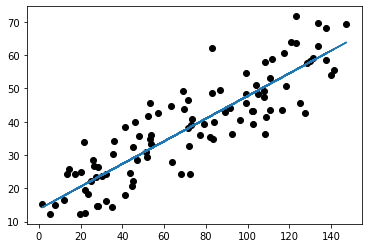

In [6]:
plt.scatter(x=X_train, y=y_train, c='black')
# y = a*x + b
plt.plot(X_train, real_a*X_train + real_b)
plt.show()

### Решение с помощью линейной алгебры

In [7]:
# Используем функцию, написанную выше, чтобы найти W и b, с помощью метода наименьших квадратов
solve_weights(X_train.reshape(-1, 1), y_train)

In [8]:
# Полученные веса лежат в глобальных переменных, выведем их
W, b

(array([0.33251131]), array([14.38755693]))

Полученные веса очень похожи на те, которые мы задавали при генерации данных. Значит модель получилась хорошей.

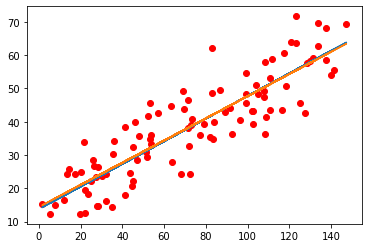

In [9]:
# Выведем данные, истинную зависимость и полученную нами с помощью метода наименьших квадратов
plt.scatter(X_train, y_train, c='r')
plt.plot(X_train, real_a*X_train + real_b)
plt.plot(X_train, np.squeeze(X_train.reshape(-1, 1) @ W + b.reshape(-1, 1)))
plt.show()

### Решение с помощью градиентного спуска

In [12]:
# Найдем параметры с помощью градиентного спуска
# чтобы проследить за обучением, мы записываем значение функции ошибки на каждом шаге и после выводим
losses = grad_descent(X_train.reshape(-1, 1), y_train, 1e-9, 15000)

In [13]:
# Полученные веса лежат в глобальных переменных, выведем их
W, b

(array([0.47935297]), array([0.57274239]))

Веса модели получились не похожи, на то, что мы задавали при генерации данных. Модель намного хуже.

Стоит отметить, что хуже всего был подобран свободный член b, это связано с тем, что данные не нормализованы и параметры a и b имеют очень разные модули, а шаги, которые делает градиентный спуск для обоих параметров одного порядка. Это приводит к тому, что меньший по модулю параметр a быстро подбирается, а параметр почти b перестает изменяться.

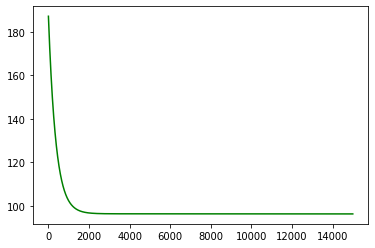

In [16]:
# Выведем график функции потерь 
plt.figure()
plt.plot(losses, 'g')
plt.show()

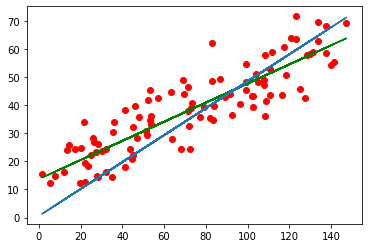

In [17]:
# Выведем данные, истинную зависимость и полученную нами
plt.scatter(X_train, y_train, c='r')
plt.plot(X_train, real_a*X_train + real_b, c='g')
plt.plot(X_train, np.squeeze(X_train.reshape(-1, 1) @ W + b.reshape(-1, 1)))
plt.show()

Градиентный спуск восстановил зависимость хуже, чем метод наименьших квадратов, это вызвано тем, что 
* данные не **нормализованы** (подробнее о нормализации в домашнем ноутбуке).
* в **методе наименьших квадратов** мы получали решение **аналитически**, поэтому оно гарантировано является наилучшим, в то время как градиентный спуск находит решение лишь приближенно. 

Возникает вопрос, зачем использовать **градиентный спуск**, если он хуже **аналитических** методов? Дело в том, что оптимизация большого количества весов в **нейронных сетях** сликшом сложная задача, которая не может быть решена **аналитически**.

### Работа с другими данными

Загрузим с помощью **pandas** реальные данные из файла **data.csv** и найдем параметры зависимости с помощью метода наименьших квадратов и градиентного спуска, как и в предыдущем примере (так как наш код универсален, нам просто нужно просто вызвать те же функции).

In [21]:
data_comp = pd.read_csv('data.csv', index_col='Index')
data_comp.head()

# так как данные многомерные, мы не можем построить график, как в предыдущем примере, 
# чтобы увидеть зависимость глазами. Поэтому мы просто выведем первые строки таблицы.

,A1,A2,A3,A4,B
Index,,,,,
1,75,91,6,85,4815
2,6,48,48,48,234
3,5,60,24,40,160
4,74,48,8,86,4794
5,10,74,70,11,659


In [41]:
# разделим данные на признаки и значения
Y_data = np.array(data_comp.B)
Y_data

array([ 4815,   234,   160,  4794,   659,  4551,  3150,  6014,  5017,
        6353,  1399,  6550,   606,  6081,  2392,  3194,  4553,  6244,
        6379,  2594,  2750,  5024,  3191,  5440,  2014,  1140,  6084,
        4773,  2909,   164,    11,  3507,  3107,  2690,  4162,  1898,
        2902,  4162,  3427,  3861,  1268,  3549,  5538,  1484,  3363,
        4990,  5739,  5287,  3450,  9340,  7806,  5089,  8200,  5980,
        3351,  7925,  5030,  6031,  3051,  1969,  5961,  9330,  2433,
        4422,  5490, 10155,  6972,  2341,   662, 10302,  3524,  5117,
        3057,  6589,  1005,  6568,  4790,  7151,   982,  2745,  3691,
        4284,  1981,  2859,  4105,  3544,  7278,  8697,  2625, -3326,
        5197,   -51,  5185,  2823,  3697,    65], dtype=int64)

In [42]:
X_data = np.array(data_comp.drop('B', axis=1))
X_data

array([[ 75,  91,   6,  85],
       [  6,  48,  48,  48],
       [  5,  60,  24,  40],
       [ 74,  48,   8,  86],
       [ 10,  74,  70,  11],
       [ 67,  89,  32,  19],
       [ 49,  36,  32,  68],
       [ 90,  49,  95,  82],
       [ 74,  90,   9,  19],
       [ 94,  49,  19,  47],
       [ 21,   3,  90,  38],
       [ 95,  21,  60,  34],
       [ 14,  50,   7,  84],
       [ 89,  46,  65,  44],
       [ 38,  83,  62,  63],
       [ 48,  67,  33,  33],
       [ 70,  88,  91,  86],
       [ 92,  41,  62,  53],
       [ 92,   3,   4,  17],
       [ 43,  54,   7,  93],
       [ 40,  75,  86,  15],
       [ 74,  64,  72,  39],
       [ 50,  61,  46,  71],
       [ 78,   5,  60,  20],
       [ 32,  13,  14,  56],
       [ 21,  34,  18,  78],
       [ 88,  96,  17,   1],
       [ 71,   4,  74,  67],
       [ 43,  29,  10,  19],
       [  3,  32,  96,  29],
       [  5,  82,  22,  72],
       [ 50,  54,  64,   2],
       [ 48,  33,  54,  67],
       [ 42,  82,   8,  46],
       [ 65,  

### Решение с помощью линейной алгебры

In [43]:
# Используем функцию, написанную выше, чтобы найти W и b, с помощью метода наименьших квадратов
solve_weights(X_data, Y_data)

In [44]:
# Полученные веса лежат в глобальных переменных, выведем их
W, b

(array([ 3.29211245,  6.54097099, 24.3858116 , -7.47819654]),
 array([2030.27050104]))

In [45]:
# Выведем значение функции ошибки, чтобы позже сравнить с результатом градиентного спуска
mse(predict(X_data), Y_data)

3731984.960573224

### Решение с помощью градиентного спуска

In [46]:
# Найдем параметры с помощью градиентного спуска
# чтобы проследить за обучением, мы записываем значение функции ошибки на каждом шаге и после выводим
losses = grad_descent(X_data, Y_data, 1e-9, 500)

In [47]:
# Полученные веса лежат в глобальных переменных, выведем их
W, b

(array([11.46668915, 11.89931765, 11.30305707,  6.64896169]),
 array([0.99149112]))

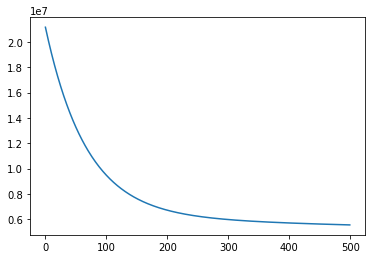

In [49]:
# Выведем график функции потерь 
plt.plot(losses)
plt.show()

In [50]:
# Выведем значение функции ошибки
mse(predict(X_data), Y_data)

5553259.964069035

Как мы видим, **градиентный спуск** опять нашел значительно более плохое решение. Если нормализовать данные, то **градиентный спуск** будет сходиться лучше и разница будет не такой заметной. 

In [52]:
a_data = np.array([ 3.29211245,  6.54097099, 24.3858116 , -7.47819654])
b_data = np.array([2030.27050104])
a_data, b_data

(array([ 3.29211245,  6.54097099, 24.3858116 , -7.47819654]),
 array([2030.27050104]))

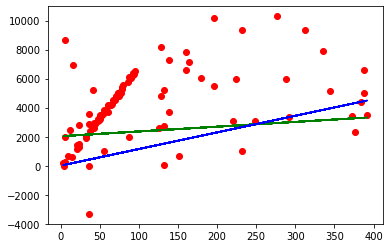

In [74]:
# X1
plt.scatter(X_data[:,0], Y_data, c='r')
plt.plot(X_data[:,0], X_data[:,0]*a_data[0] + b_data, c='g')
plt.plot(X_data[:,0], X_data[:,0]*W[0] + b, c='b')
plt.show()

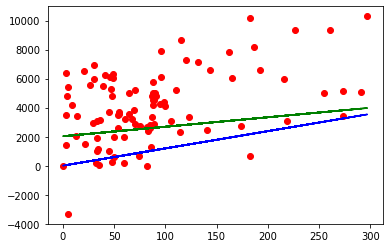

In [75]:
# X1
plt.scatter(X_data[:,1], Y_data, c='r')
plt.plot(X_data[:,1], X_data[:,1]*a_data[1] + b_data, c='g')
plt.plot(X_data[:,1], X_data[:,1]*W[1] + b, c='b')
plt.show()